# 5xFAD Resting State EEG


In [60]:
import os
import dill as pickle
import scienceplots
import numpy as np
import importlib

from prompt_toolkit.shortcuts import yes_no_dialog
import tqdm.notebook as tqdm

import openephysextract

from openephysextract.utilities import savify
from openephysextract.utilities import loadify

from matplotlib import pyplot as plt

plt.style.use(['science', 'grid'])
plt.rc('figure', titlesize = 33, figsize = (21, 7), dpi = 210)
plt.rc('axes', titlesize = 27, labelsize = 21, titlepad = 21)
plt.rc('xtick', labelsize = 17)
plt.rc('ytick', labelsize = 17)

source = '/Volumes/STORAGE 1.0/UNIC Research/5xFAD Resting State'
channels = [3, 4, 5, 6, 7, 8]
sampling_rate = 30000
output_1 = os.path.join(source, 'processed')
output_2 = '/Users/fomo/Documents/Research/UNIC Research/Motor Evoked Potentials/resting state analysis'

## I Preprocessing

### I.I Extraction

In [ ]:
importlib.reload(openephysextract.extractor)
from openephysextract.extractor import Extractor  

extractor = Extractor(
    source = source,
    channels = channels,
    sampling_rate = sampling_rate,
    output = output_1,
)

out = extractor.extractify(export = True)

### I.II Preprocessing

In [ ]:
with open(os.path.join(output_1, 'raw_data.pkl'), 'rb') as f:
    extracted = pickle.load(f)

In [ ]:
import openephysextract.preprocess
importlib.reload(openephysextract.preprocess)
from openephysextract.preprocess import (
    Preprocessor,
    RemoveBadStep,
    FilterStep,
    DownsampleStep,
    EpochStep
)

# Step 2 — Define your preprocessing pipeline
steps = [
    RemoveBadStep(alpha=0.3, beta=0.7),
    DownsampleStep(target_fs=300),
    FilterStep(lowcut=0.1, highcut=80, order=4),
    EpochStep(frame=300, stride=30),
]

# Step 3 — Instantiate and run the processor
processor = Preprocessor(trials=extracted, steps=steps, destination=output_2)
processor.preprocess(parallel=False, export=True)

## II Analysis

In [ ]:
processed = loadify(output_2, 'preprocessed_trials.pkl')

### II.I PSD Analysis

In [ ]:
import openephysextract.analysis
importlib.reload(openephysextract.analysis)
from openephysextract.analysis import bandpower

features = [bandpower(trial) for trial in processed]

savify(features, output_2, 'features')

In [ ]:
features = loadify(output_2, 'features')

### II.II Logistic Scaling (Garwood et. al)

In [ ]:
import openephysextract.analysis
importlib.reload(openephysextract.analysis)
from openephysextract.analysis import logistic_scaler as scaler

scaled = [scaler(trial) for trial in features]

savify(scaled, output_2, "logistic-scaled")

In [61]:
scaled = loadify(output_2, "logistic-scaled")
scaled[0].data.shape

Loaded from /Users/fomo/Documents/Research/UNIC Research/Motor Evoked Potentials/resting state analysis/logistic-scaled.pkl


(3523, 4, 5)

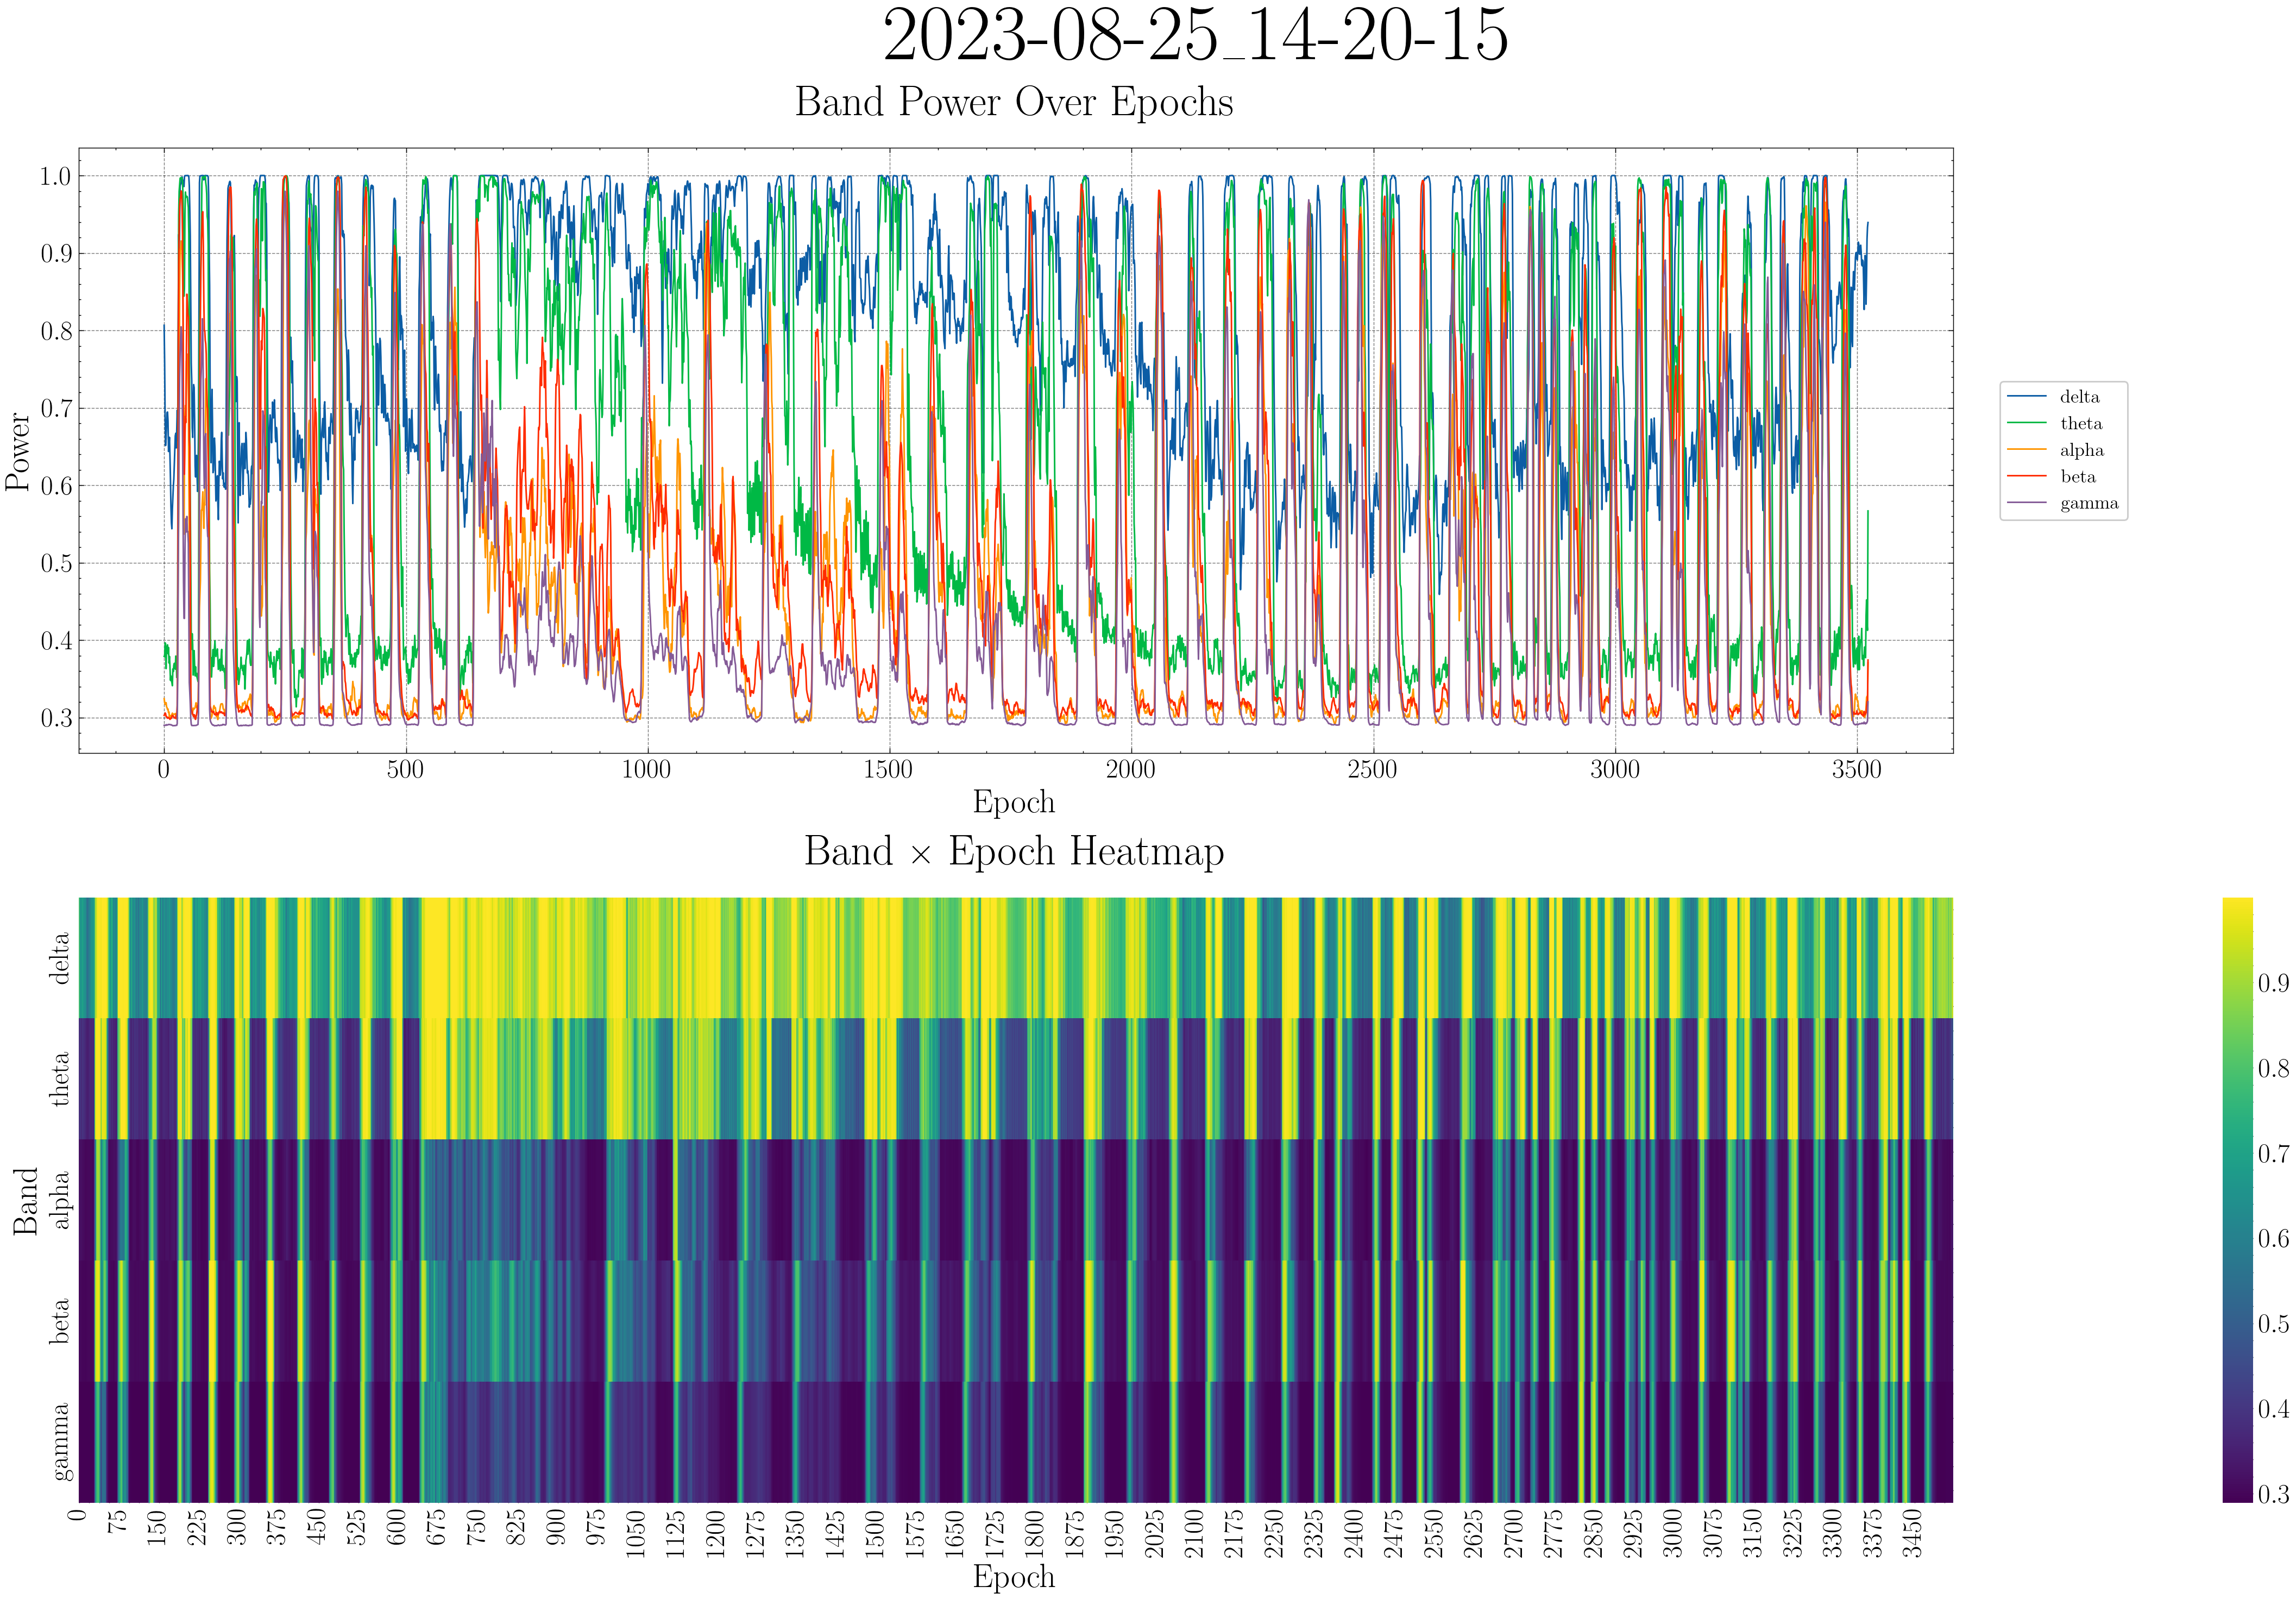

In [9]:
import openephysextract.plot
importlib.reload(openephysextract.plot)
from openephysextract.plot import plotifyEEGbands

plotifyEEGbands(scaled[0])

## III beta-HMM Construction

### III.I 

In [14]:
X = np.vstack([
    trial.data.reshape(trial.data.shape[0], -1)
    for trial in scaled
])

X.shape

(53963, 20)

In [95]:
import numpy as np
from scipy.special import logsumexp
from scipy.stats import beta
from tqdm import tqdm

class BetaHMM:
    """
    Hidden Markov Model with beta emission distributions.
    Optimized for vectorized forward/backward and EM convergence.
    """
    def __init__(self, n_states, n_features, seed=None):
        self.K = n_states
        self.D = n_features
        self.rng = np.random.default_rng(seed)

        # model parameters
        self.pi = self.rng.dirichlet(np.ones(self.K))               # initial state distribution
        self.A  = self.rng.dirichlet(np.ones(self.K), size=self.K)  # transition matrix
        # beta parameters to ensure unimodal; will be re-estimated
        self.alpha = self.rng.uniform(1.5, 3.0, size=(self.K, self.D))
        self.beta  = self.rng.uniform(1.5, 3.0, size=(self.K, self.D))

    def _compute_ll(self, Y):
        """
        Compute log-likelihood matrix of shape (N, K).
        """
        Y = np.clip(Y, 1e-6, 1 - 1e-6)
        return np.stack([
            np.sum(beta.logpdf(Y, self.alpha[k], self.beta[k]), axis=1)
            for k in range(self.K)
        ], axis=1)

    def _forward(self, LL, log_pi, log_A):
        N, K = LL.shape
        log_alpha = np.zeros((N, K))
        log_alpha[0] = log_pi + LL[0]
        for n in range(1, N):
            log_alpha[n] = LL[n] + logsumexp(log_alpha[n-1][:, None] + log_A, axis=0)
        return log_alpha

    def _backward(self, LL, log_A):
        N, K = LL.shape
        log_beta = np.zeros((N, K))
        for n in range(N-2, -1, -1):
            log_beta[n] = logsumexp(
                log_A + LL[n+1][None, :] + log_beta[n+1][None, :],
                axis=1
            )
        return log_beta

    def _compute_gamma_xi(self, log_alpha, log_beta, LL, log_A):
        N, K = log_alpha.shape
        # gamma: posterior state marginals
        log_gamma = log_alpha + log_beta
        log_gamma -= logsumexp(log_gamma, axis=1, keepdims=True)
        gamma = np.exp(log_gamma)

        # xi: posterior transition counts
        xi = np.zeros((N-1, K, K))
        for n in range(N-1):
            log_xi_raw = (
                    log_alpha[n][:, None] + log_A +
                    LL[n+1][None, :] + log_beta[n+1][None, :]
            )
            log_xi = log_xi_raw - logsumexp(log_xi_raw)
            xi[n] = np.exp(log_xi)
        return gamma, xi

    def em_step(self, Y):
        LL      = self._compute_ll(Y)
        log_pi  = np.log(np.clip(self.pi, 1e-12, 1.0))
        log_A   = np.log(np.clip(self.A,  1e-12, 1.0))
        log_a   = self._forward(LL, log_pi, log_A)
        log_b   = self._backward(LL, log_A)
        gamma, xi = self._compute_gamma_xi(log_a, log_b, LL, log_A)

        # M-step: update pi and A
        self.pi = gamma[0]
        A_counts = xi.sum(axis=0)
        self.A = A_counts / A_counts.sum(axis=1, keepdims=True)

        # update beta parameters via weighted moments
        for k in range(self.K):
            w = gamma[:, k]
            w_sum = w.sum()
            if w_sum < 1e-8:
                continue
            mean = (w[:, None] * Y).sum(axis=0) / w_sum
            var  = (w[:, None] * (Y - mean)**2).sum(axis=0) / w_sum
            var  = np.clip(var, 1e-4, None)
            v    = np.maximum(mean * (1 - mean) / var - 1, 1e-2)
            self.alpha[k] = np.clip(mean * v,     1e-2, 1e2)
            self.beta[k]  = np.clip((1 - mean)*v, 1e-2, 1e2)

        return logsumexp(log_a[-1])

    def fit(self, Y, max_iters=100, tol=1e-4):
        """
        Run EM until convergence or max iterations on a single sequence.
        """
        prev_ll = -np.inf
        for _ in range(max_iters):
            ll = self.em_step(Y)
            if ll - prev_ll < tol:
                break
            prev_ll = ll
        return self

    def fit_multi(self, Y_list, max_iters=50, tol=1e-4):
        """
        Fit a single Beta-HMM across multiple independent sequences.
        """
        prev_ll = -np.inf

        for _ in tqdm(range(max_iters)):
            total_ll = 0.0
            # Reset accumulators each iteration
            pi_acc      = np.zeros(self.K)
            A_acc       = np.zeros((self.K, self.K))
            sum_weight  = np.zeros(self.K)
            sum_Y       = np.zeros((self.K, self.D))
            sum_Y2      = np.zeros((self.K, self.D))

            # E-step: loop over trials
            for Y in Y_list:
                LL      = self._compute_ll(Y)
                log_pi  = np.log(np.clip(self.pi, 1e-12, 1.0))
                log_A   = np.log(np.clip(self.A,  1e-12, 1.0))
                log_a   = self._forward(LL, log_pi, log_A)
                log_b   = self._backward(LL, log_A)
                gamma, xi = self._compute_gamma_xi(log_a, log_b, LL, log_A)

                total_ll += logsumexp(log_a[-1])
                pi_acc   += gamma[0]
                A_acc    += xi.sum(axis=0)

                for k in range(self.K):
                    w = gamma[:, k]
                    sum_weight[k] += w.sum()
                    sum_Y[k]      += (w[:, None] * Y).sum(axis=0)
                    sum_Y2[k]     += (w[:, None] * (Y**2)).sum(axis=0)

            # M-step: update shared parameters
            self.pi = pi_acc / pi_acc.sum()
            self.A  = A_acc  / A_acc.sum(axis=1, keepdims=True)

            for k in range(self.K):
                mean = sum_Y[k] / sum_weight[k]
                var  = (sum_Y2[k] / sum_weight[k]) - mean**2
                var  = np.clip(var, 1e-4, None)
                prec = np.maximum(mean * (1 - mean) / var - 1, 1e-2)
                self.alpha[k] = np.clip(mean * prec,     1e-2, 1e2)
                self.beta[k]  = np.clip((1 - mean)*prec, 1e-2, 1e2)

            if total_ll - prev_ll < tol:
                break
            prev_ll = total_ll

        return self

    def viterbi(self, Y):
        """
        Decode one sequence into its most likely state path.
        """
        LL    = self._compute_ll(Y)
        N, K  = LL.shape
        delta = np.zeros((N, K))
        psi   = np.zeros((N, K), dtype=int)

        delta[0] = np.log(np.clip(self.pi, 1e-12, 1.0)) + LL[0]
        log_A    = np.log(np.clip(self.A, 1e-12, 1.0))

        for n in range(1, N):
            scores     = delta[n-1][:, None] + log_A
            psi[n]     = np.argmax(scores, axis=0)
            delta[n]   = scores[psi[n], range(K)] + LL[n]

        states = np.zeros(N, dtype=int)
        states[-1] = np.argmax(delta[-1])
        for n in range(N-2, -1, -1):
            states[n] = psi[n+1, states[n+1]]

        return states

    def viterbi_multi(self, Y_list):
        """
        Decode each sequence in Y_list independently.
        """
        return [self.viterbi(Y) for Y in Y_list]


### III.II Model Order Selection

In [93]:
Ys = [t.data.reshape(t.data.shape[0], -1) for t in scaled]

  6%|▌         | 3/50 [00:12<03:16,  4.18s/it]


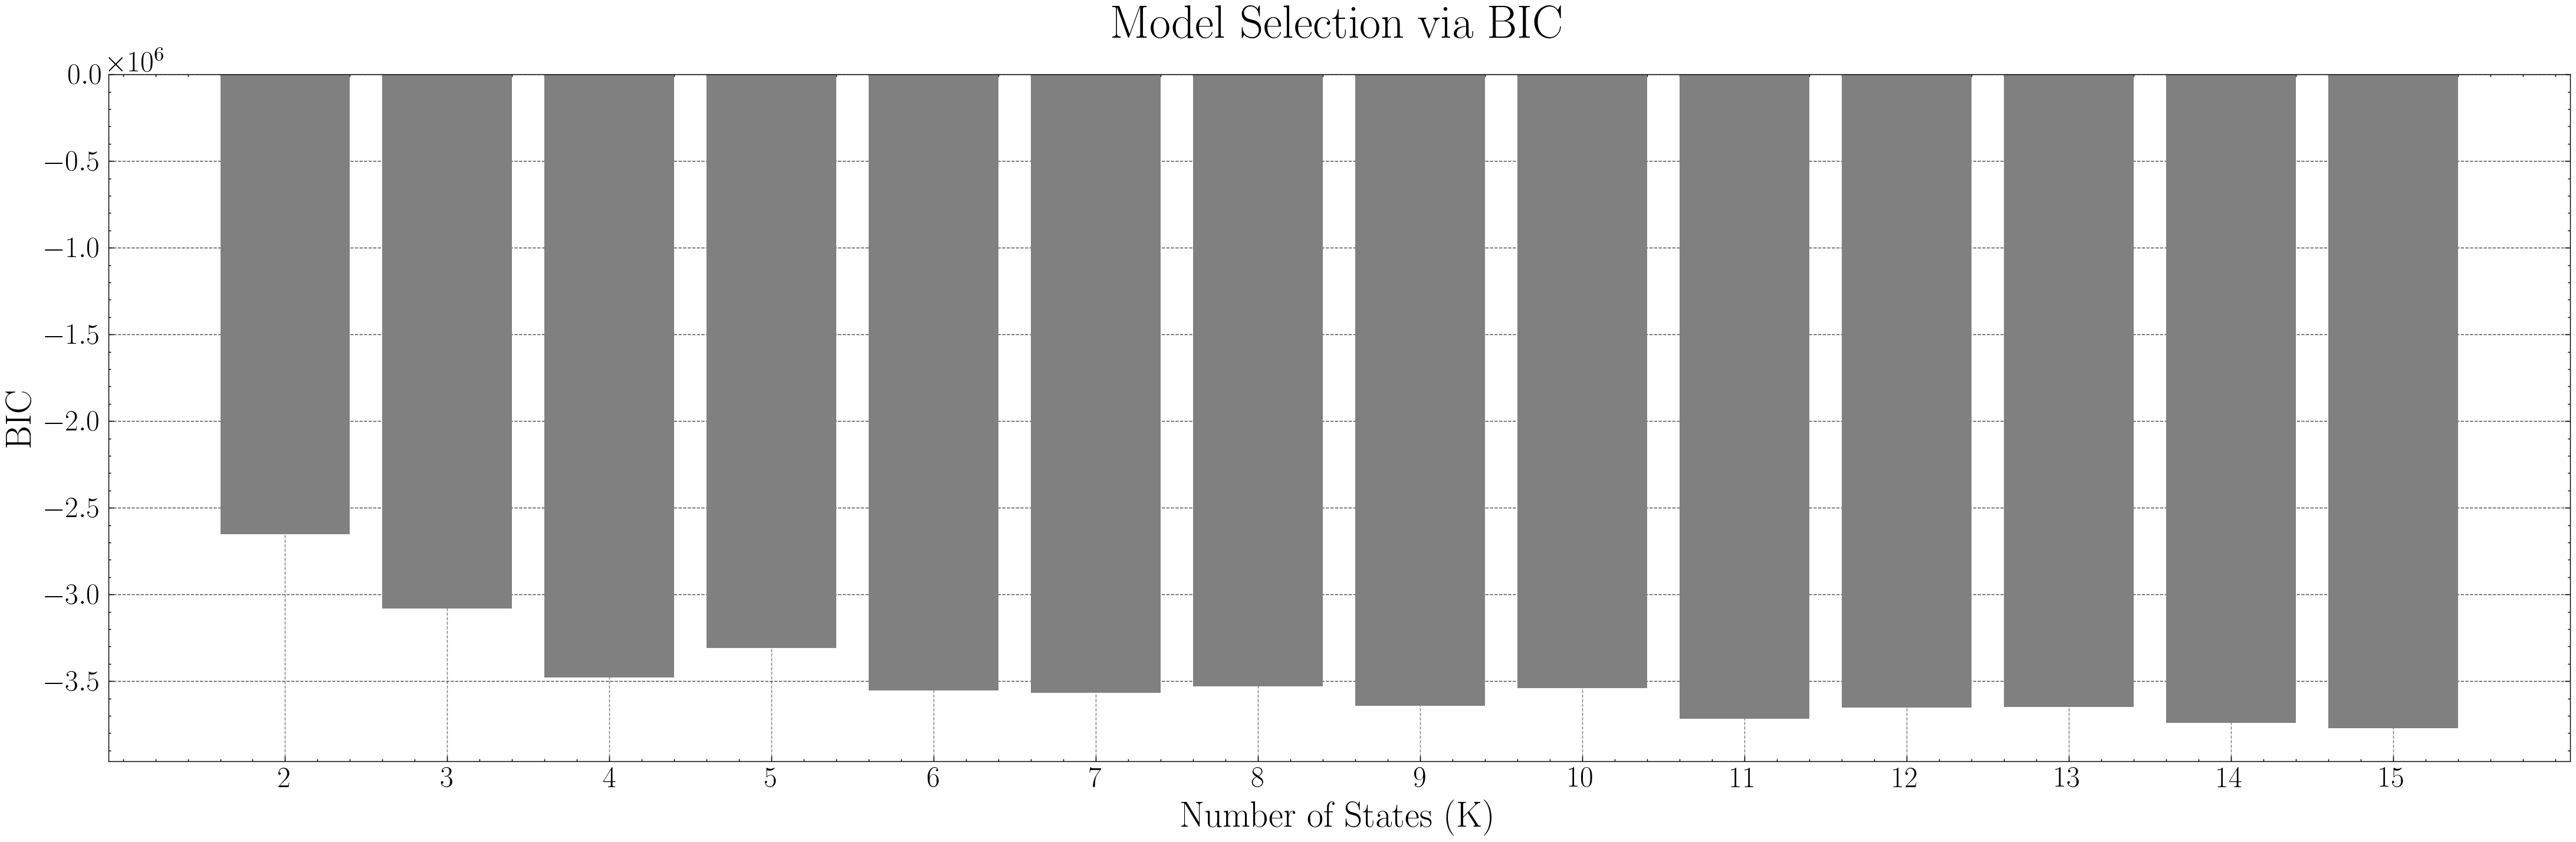

In [99]:
bic_scores = []

models = {}

Ks = range(2, 16)
for K in Ks:
    model = BetaHMM(n_states=K, n_features=Ys[0].shape[1], seed=0)
    model.fit_multi(Ys)
    ll = sum(model._compute_ll(Y).max(axis=1).sum() for Y in Ys)  # or store EM log-likelihood
    N_total = sum(Y.shape[0] for Y in Ys)

    p = (K - 1) + K*(K - 1) + 2 * K * model.D
    bic = -2 * ll + p * np.log(N_total)
    bic_scores.append(bic)
    
    models[f"K: {K}"] = model
    
best_K = Ks[np.argmin(bic_scores)]
colors = ['red' if i == best_K else 'gray' for i in range(len(Ks))]

plt.figure(figsize=(21, 7), dpi = 210)
plt.bar(Ks, bic_scores, color=colors)
plt.xlabel('Number of States (K)')
plt.ylabel('BIC')
plt.title('Model Selection via BIC')
plt.xticks(Ks)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [100]:
best_K, bic_scores, models

(15,
 [-2651738.3567978535,
  -3082658.166701314,
  -3479403.1150675267,
  -3310055.9381487714,
  -3555207.096914644,
  -3568413.1746347267,
  -3529648.7711789915,
  -3643395.615889492,
  -3539380.255593138,
  -3718511.402683962,
  -3652231.9047006764,
  -3647961.53916165,
  -3740428.8876672904,
  -3772712.0865041837],
 {'K: 2': <__main__.BetaHMM at 0x3278e0f10>,
  'K: 3': <__main__.BetaHMM at 0x327a86f10>,
  'K: 4': <__main__.BetaHMM at 0x327d6c160>,
  'K: 5': <__main__.BetaHMM at 0x325b44070>,
  'K: 6': <__main__.BetaHMM at 0x327af33d0>,
  'K: 7': <__main__.BetaHMM at 0x3278e09a0>,
  'K: 8': <__main__.BetaHMM at 0x3278e0ee0>,
  'K: 9': <__main__.BetaHMM at 0x325b7cb50>,
  'K: 10': <__main__.BetaHMM at 0x325b7c790>,
  'K: 11': <__main__.BetaHMM at 0x325b7c9d0>,
  'K: 12': <__main__.BetaHMM at 0x327d82a60>,
  'K: 13': <__main__.BetaHMM at 0x327d82820>,
  'K: 14': <__main__.BetaHMM at 0x327d828b0>,
  'K: 15': <__main__.BetaHMM at 0x327d82a30>})

In [101]:
states = {}
for K, model in tqdm(models.items()):
    K = int(K.split(':')[1].strip())
    states[K] = model.viterbi_multi(Ys)

100%|██████████| 14/14 [00:11<00:00,  1.20it/s]


### III.III Visualising Dynamics

In [103]:
states.keys()

dict_keys([2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15])

#### III.III.I State Trajectory

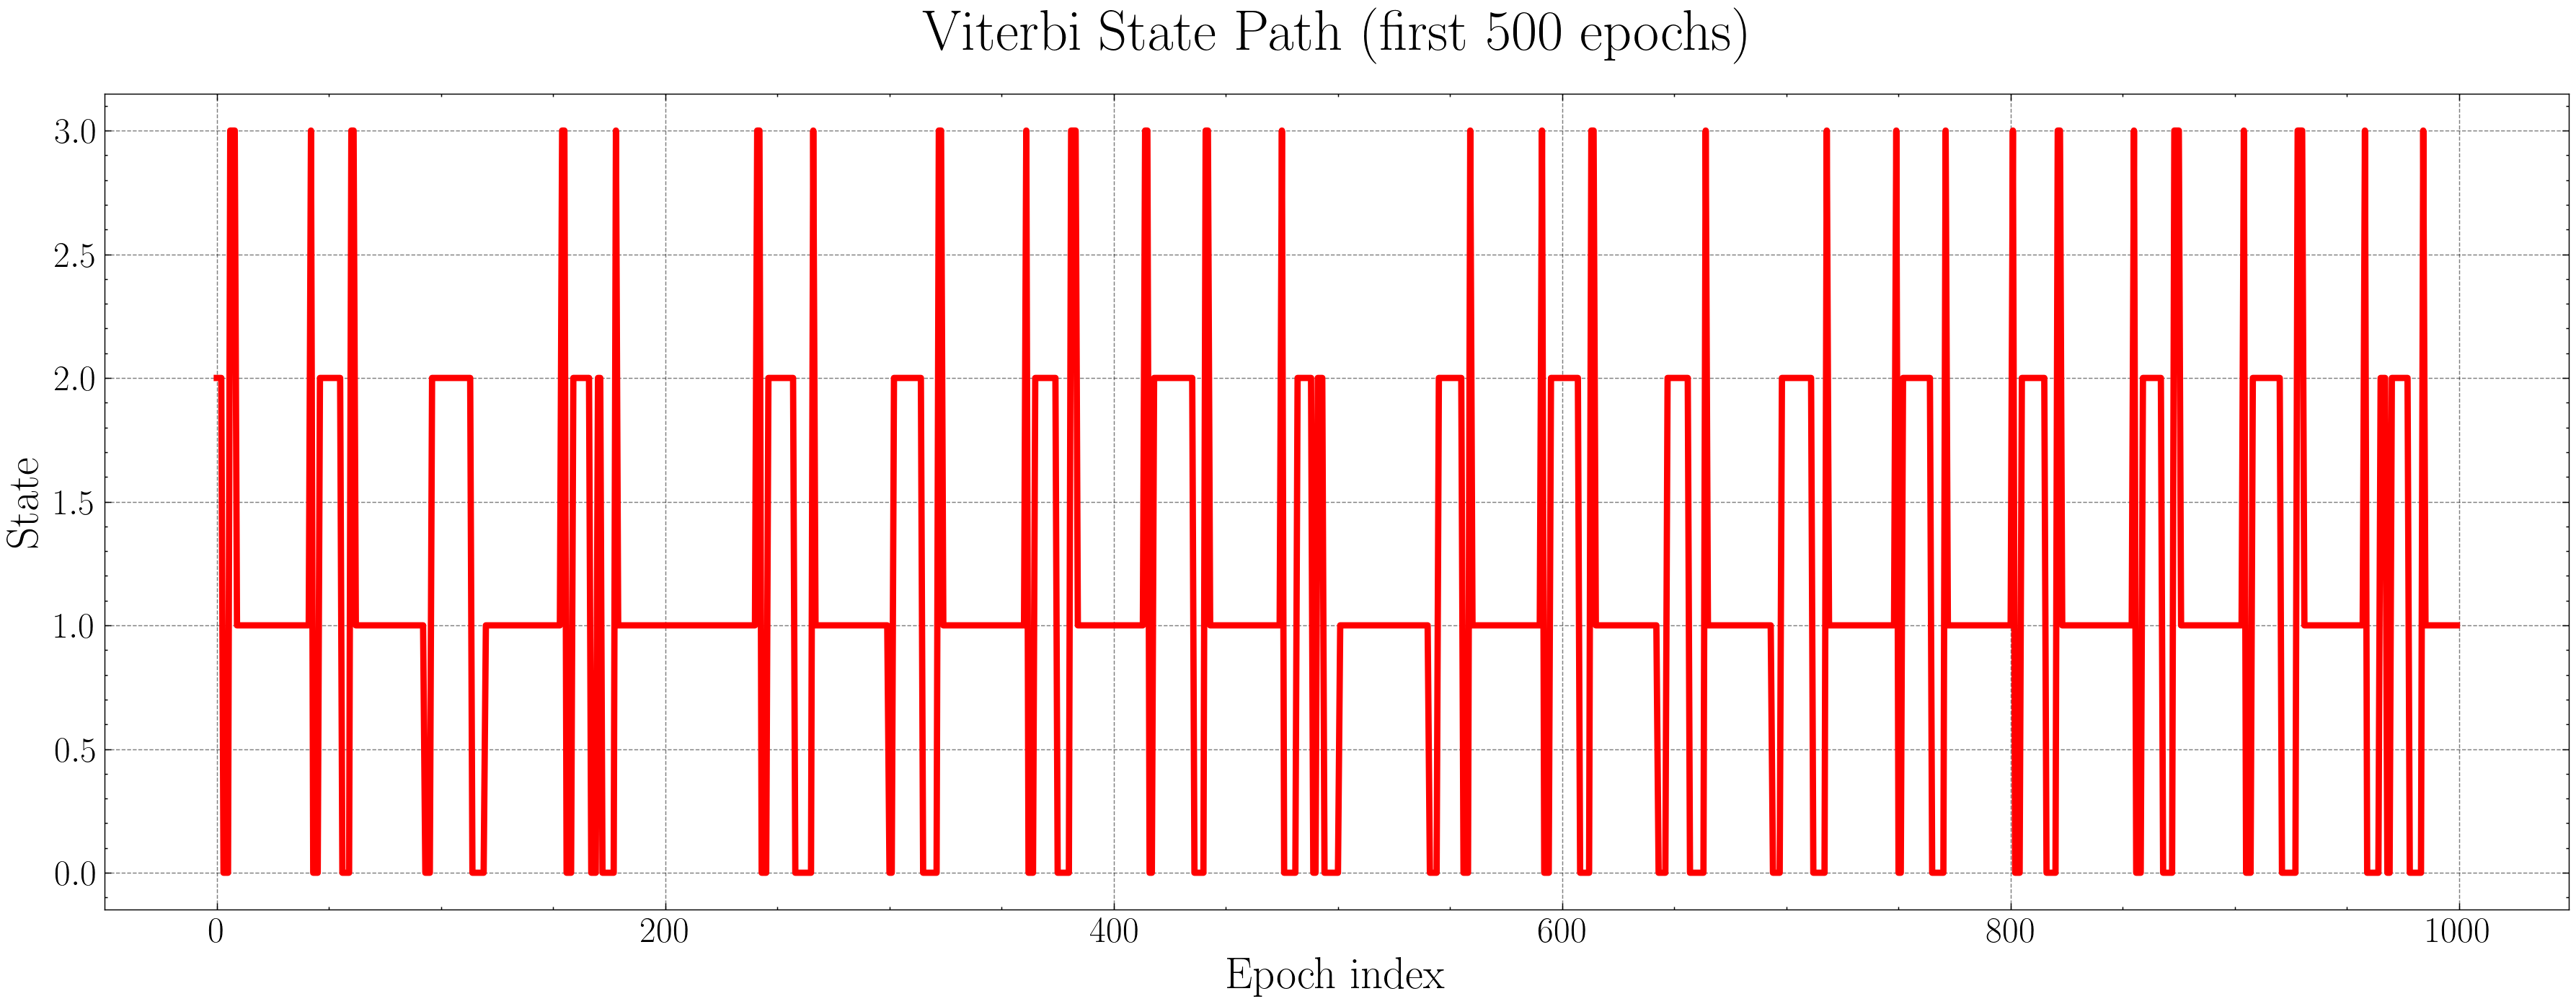

In [118]:
plt.figure(figsize=(21,7), dpi = 210)
plt.plot(states[4][5][:1000], lw=3, color = 'red')
plt.xlabel('Epoch index')
plt.ylabel('State')
plt.title('Viterbi State Path (first 500 epochs)')
plt.show()

#### III.III.II State Occupancy + Dwell Times

In [88]:
K = 2

In [85]:
import pandas as pd

# compute occupancy
occ = [(states == k).mean() for k in range(K)]
# compute dwell times
dwell_times = []
for k in range(K):
    runs = np.diff(np.where(np.concatenate([[0], states==k, [0]]))[0])
    # runs at even positions are lengths for state==k
    lengths = runs[1::2]
    dwell_times.append(lengths)


#### III.III.III Transition matrix heatmap

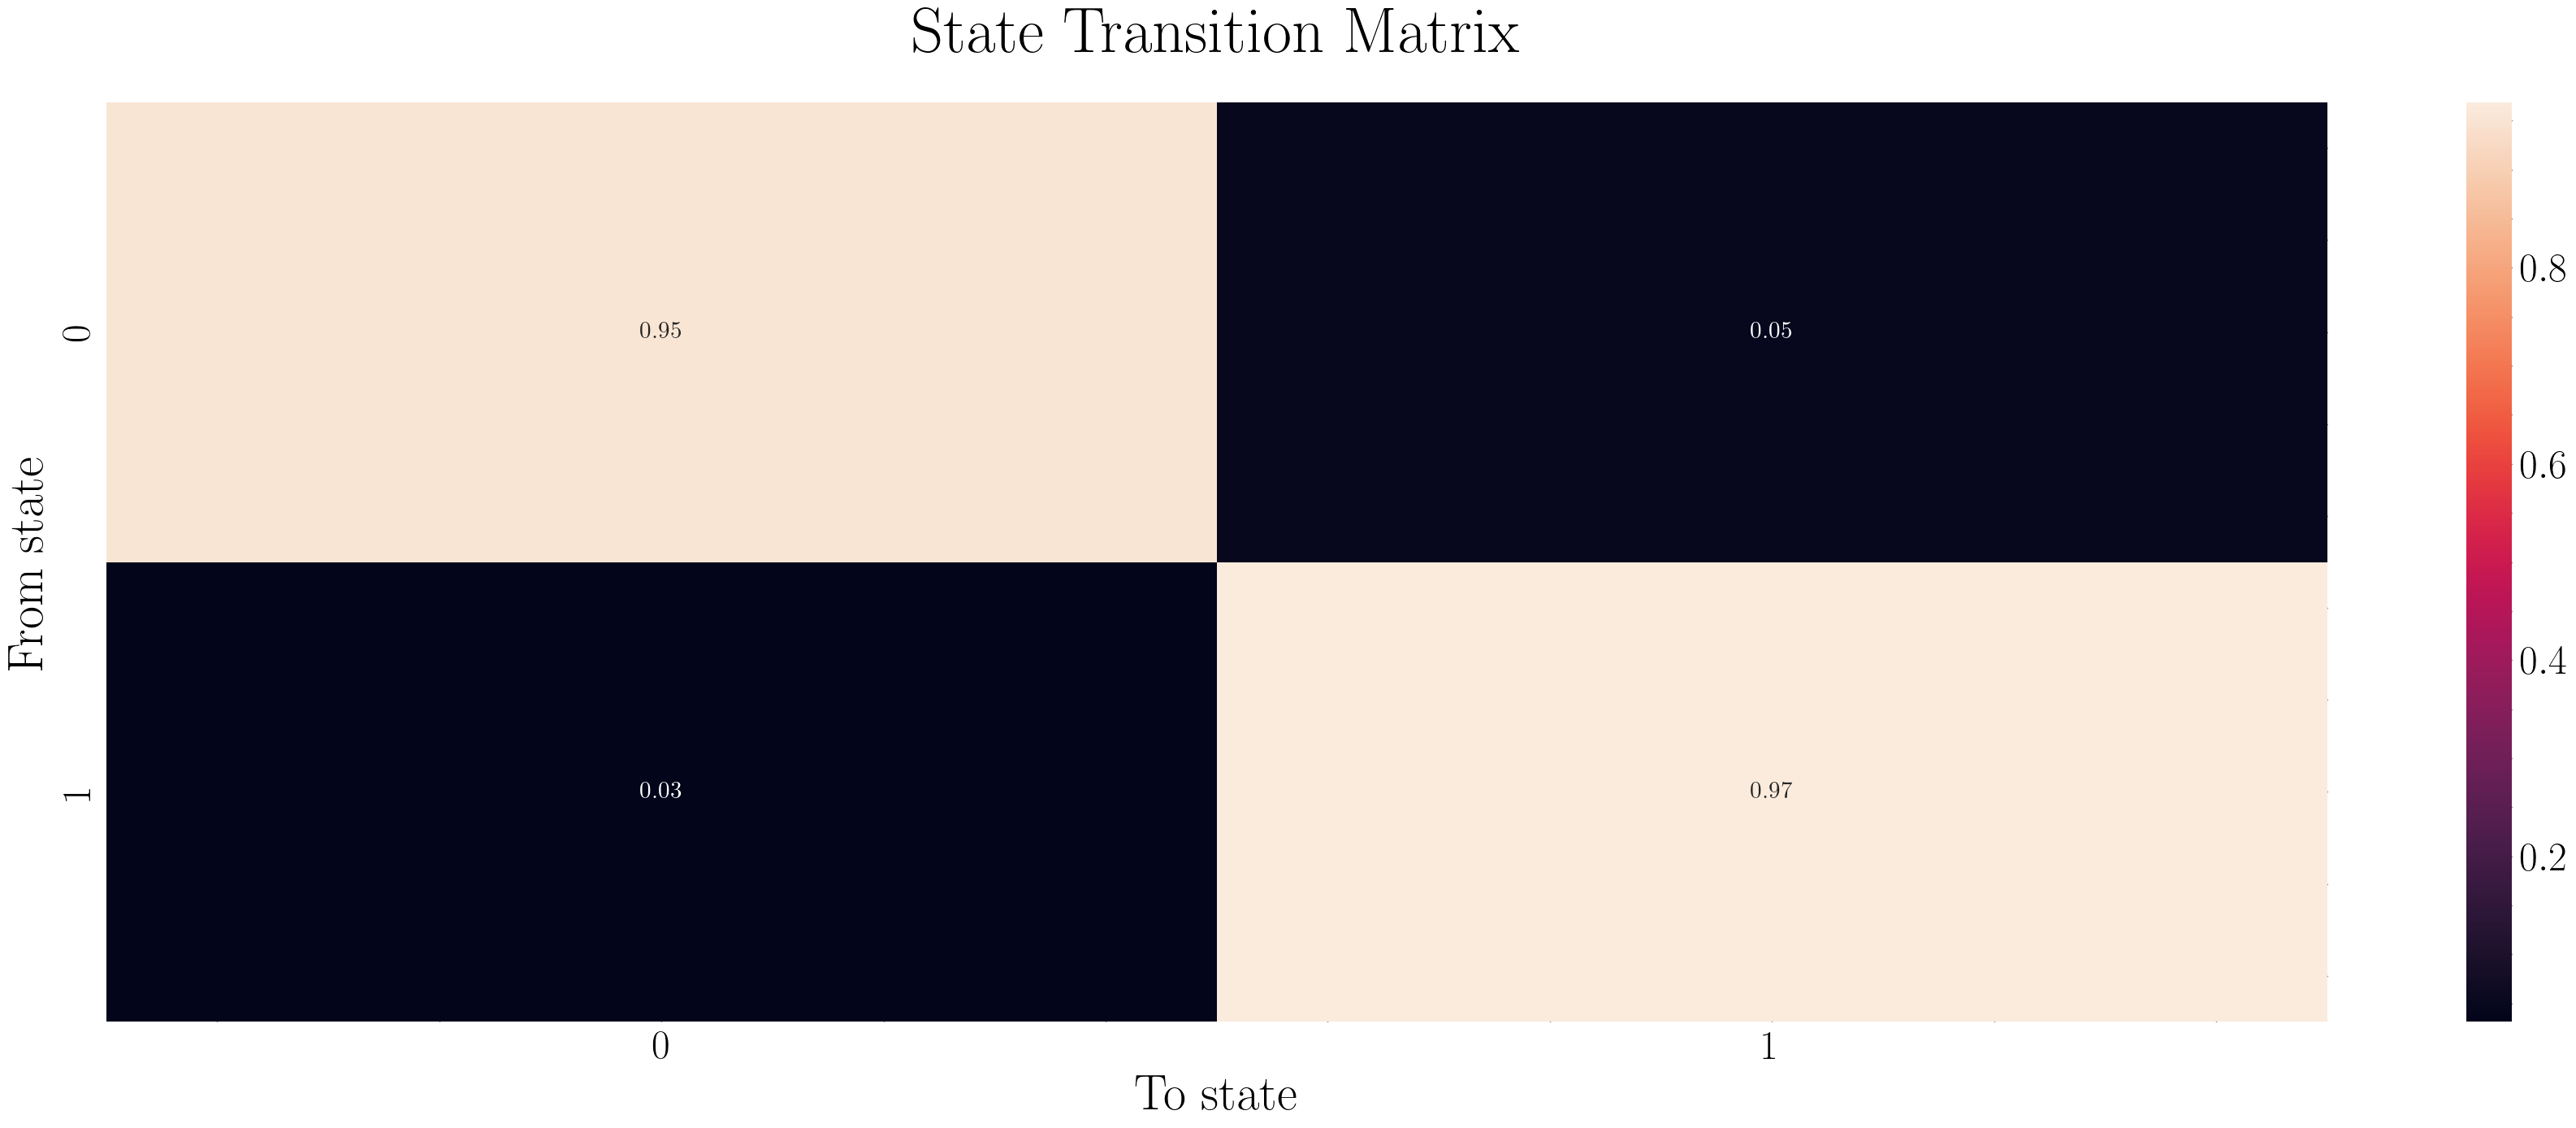

In [86]:
import seaborn as sns
plt.figure()
sns.heatmap(final.A, annot=True, fmt='.2f')
plt.title('State Transition Matrix')
plt.xlabel('To state'); plt.ylabel('From state')
plt.show()


#### III.III.IV State PDFs

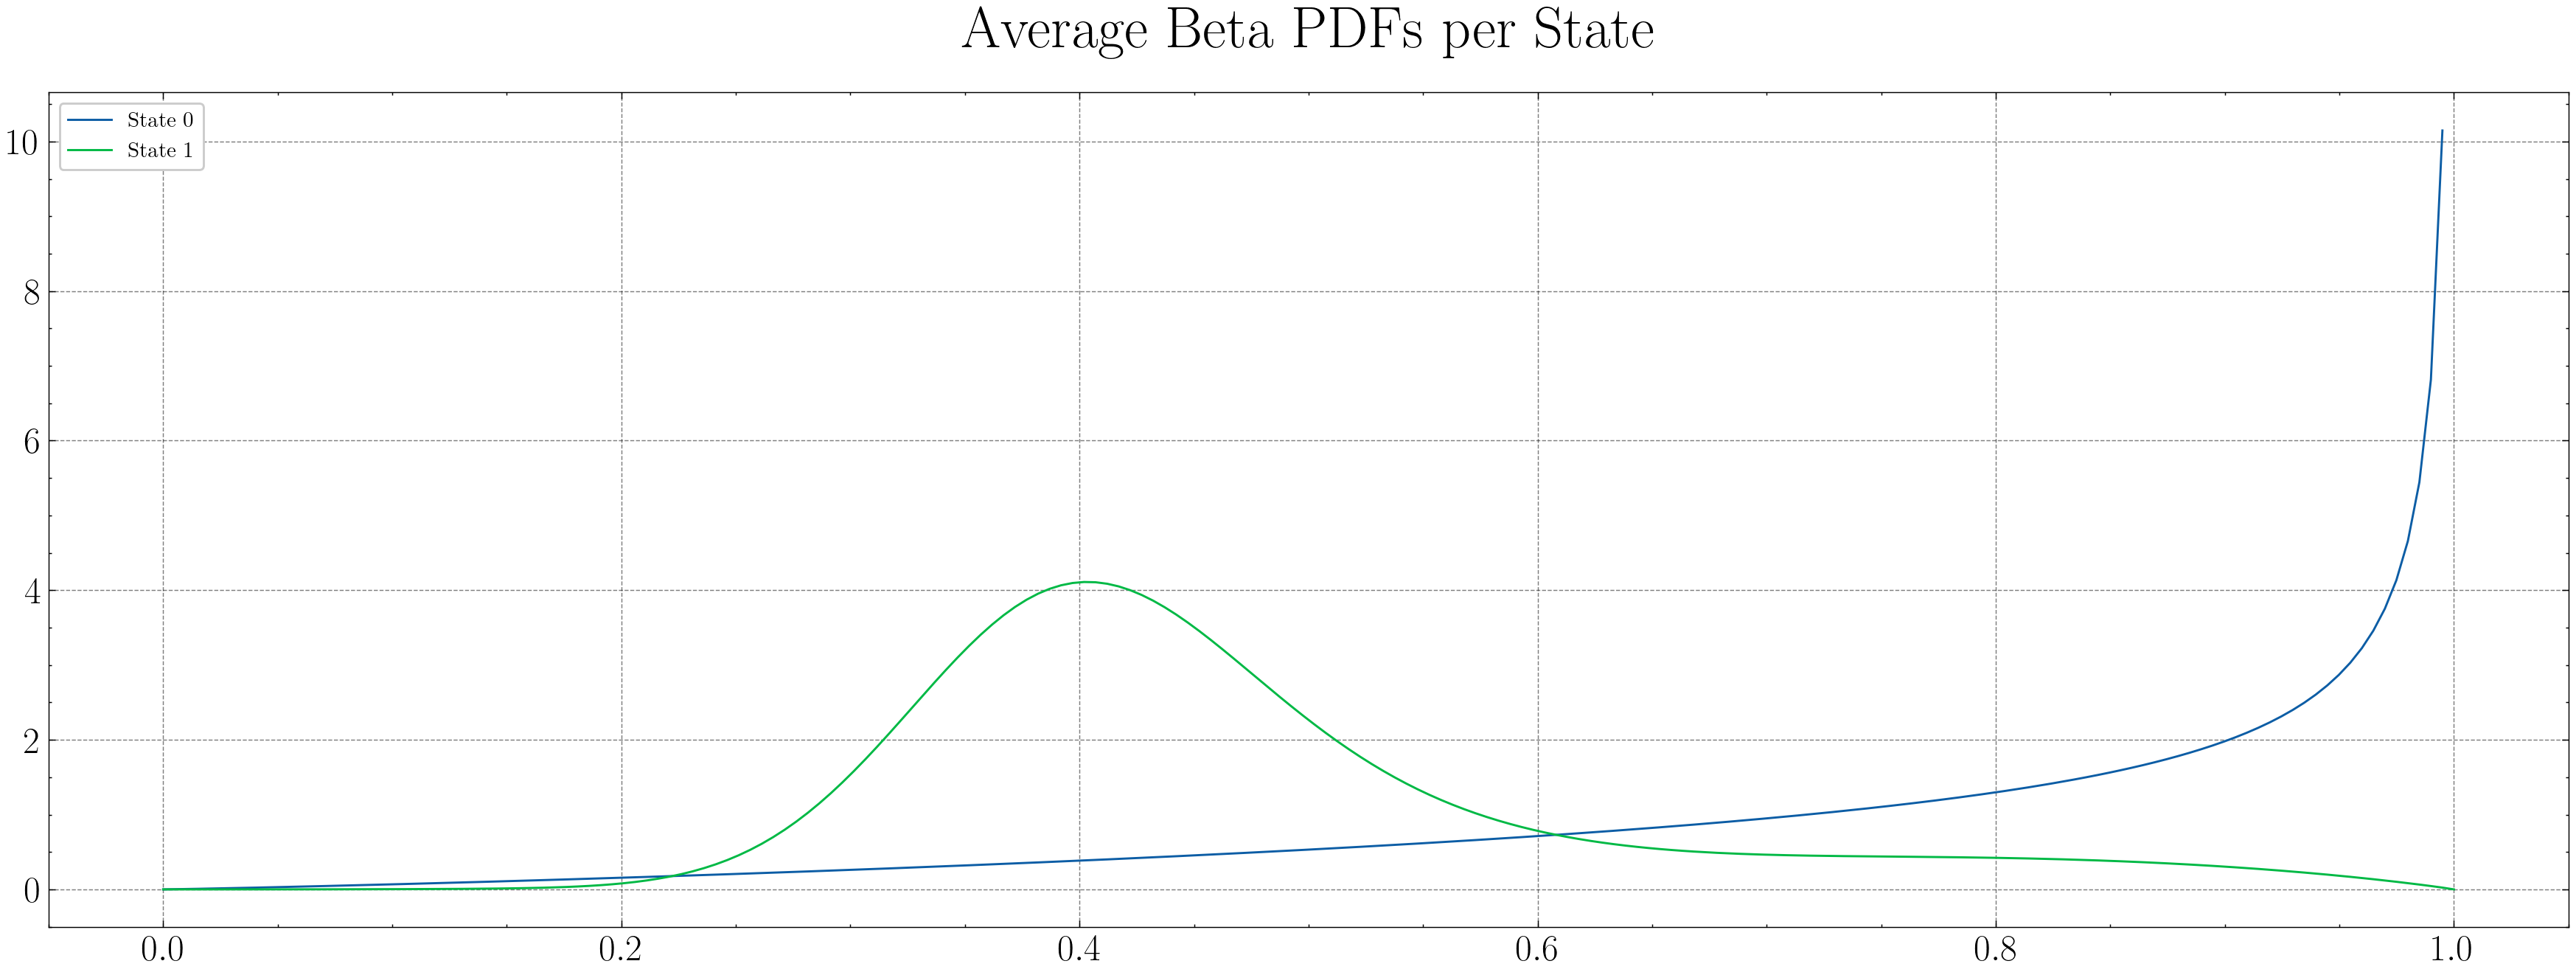

In [89]:
x = np.linspace(0,1,200)
for k in range(K):
    pdf = beta.pdf(x[:,None], final.alpha[k], final.beta[k]).mean(axis=1)
    plt.plot(x, pdf, label=f'State {k}')
plt.legend(); plt.title('Average Beta PDFs per State')
plt.show()
